In [47]:
import sys
import shutil
import time
import resource
import json
from pathlib import Path

from scipy.stats import multivariate_normal, norm

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, Callback
#from keras.metrics import AUC, RootMeanSquaredError
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import r2_score, auc, roc_curve, roc_auc_score, log_loss, fbeta_score,precision_recall_curve

import nn_models as nnm
import dataprocessing as dp
import visualization as viz

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Try Normalization Layer

In [230]:
class LSTMAutoEncoder(Model):
    def __init__(self, timesteps, input_dim, lstm_dim):
        super(LSTMAutoEncoder, self).__init__()
        self.timesteps = timesteps
        self.input_dim = input_dim
        self.lstm_dim  = lstm_dim

        self.encoder = tf.keras.models.Sequential()
        self.encoder.add(tf.keras.Input(shape=(self.timesteps, self.input_dim)))
        #self.encoder.add(tf.keras.layers.Normalization(axis = [0,-1]))
        #self.encoder.add(tf.keras.layers.LSTM(self.lstm_dim*2, activation='relu', return_sequences=True))
        self.encoder.add(tf.keras.layers.LSTM(self.lstm_dim, kernel_regularizer=tf.keras.regularizers.L2(),
                                              bias_regularizer=tf.keras.regularizers.L2(1e-4),
                                  return_sequences=False, 
                                  name = "encoder"))

        self.decoder = tf.keras.models.Sequential()
        self.decoder.add(tf.keras.layers.RepeatVector(self.timesteps))
        self.decoder.add(tf.keras.layers.LSTM(self.input_dim, activation='tanh',
                                              kernel_regularizer=tf.keras.regularizers.L2(),
                                              bias_regularizer=tf.keras.regularizers.L2(1e-4),
                                         return_sequences=True, name = 'decoder'))
        #self.decoder.add(tf.keras.layers.LSTM(self.lstm_dim*2, activation='relu', return_sequences=True))
        
        self.decoder.add(tf.keras.layers.TimeDistributed(
                                tf.keras.layers.Dense(self.input_dim, activation = 'linear')
        ))

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [231]:
### Test running the model
loss = 'mean_squared_error'
TIME_STEPS = 24
BATCH_SIZE = 16
num_features = 2

### Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min')



#model = nnm.HyperLSTMAutoEncoder(loss=loss, time_steps=TIME_STEPS, num_features=num_features)

In [232]:
### Load the data
data, target = dp.create_featured_dataset('3-jk', sensor='both', dlh=0, 
                                          keep_SH=False, keep_event=True, smote=None)

The beginning shape is:  (10221, 99)
After dropping rows with NaN in the SH_Event columns, the shape is:  (10011, 99)
NaN values in this dataset:  False
The left data frame set shape is:  (10011, 48)
The right data frame set shape is:  (10011, 48)
The keep left data frame set shape is:  (10011, 24)
The keep right data frame set shape is:  (10011, 24)
Not adding fake positive data samples.
Index(['t25_l', 't26_l', 't27_l', 't28_l', 't29_l', 't30_l', 't31_l', 't32_l',
       't33_l', 't34_l', 't35_l', 't36_l', 't37_l', 't38_l', 't39_l', 't40_l',
       't41_l', 't42_l', 't43_l', 't44_l', 't45_l', 't46_l', 't47_l', 't48_l'],
      dtype='object')
Index(['t25_r', 't26_r', 't27_r', 't28_r', 't29_r', 't30_r', 't31_r', 't32_r',
       't33_r', 't34_r', 't35_r', 't36_r', 't37_r', 't38_r', 't39_r', 't40_r',
       't41_r', 't42_r', 't43_r', 't44_r', 't45_r', 't46_r', 't47_r', 't48_r'],
      dtype='object')


In [243]:
### Split the data into train, val, and testing
target = np.where(target == 1, 1, 0)

train_idx, val_idx, test_idx = dp.split_data_cv_indx(data,target)

# Prepare data for the autoencoder model
normal, anomalous = dp.process_autoencoder(data[train_idx], data[test_idx], data[val_idx],
                                           target[train_idx], target[test_idx], target[val_idx])

normal_train, normal_val, normal_train_target, normal_val_target             = normal
anomalous_train, anomalous_val, anomalous_train_target, anomalous_val_target = anomalous

# Try Normalizing the data
#scaled_normal_train, scaled_test, scaled_normal_val = dp.normalize_data(normal_train, data[test_idx], normal_val)

train_data = normal_train # scaled_normal_train #
y_train    = normal_train_target

test_data  = data[test_idx] #scaled_test #
y_test     = target[test_idx]

val_data   = normal_val #scaled_normal_val #
y_val      = normal_val_target

print("Anomalous train data shape is: ", anomalous_train.shape)
print("Anomalous val data shape is: ", anomalous_val.shape)

Train labels shape:  (2380,)
Test labels shape:  (5836,)
Val labels shape:  (1795,)
Normal train data shape is:  (2345, 24, 2)
Normal test data shape is:  (5824, 24, 2)
Normal val data shape is:  (1783, 24, 2)
Anomalous train data shape is:  (35, 24, 2)
Anomalous test data shape is:  (12, 24, 2)
Anomalous val data shape is:  (12, 24, 2)
Anomalous train data shape is:  (35, 24, 2)
Anomalous val data shape is:  (12, 24, 2)


In [244]:
A = np.array([[[1,2,3], [4,5,6]], [[0,0,0], [1,1,1]]])
test_layer = tf.keras.layers.Normalization(axis=-1)
#test_layer.adapt(A)
test_layer(A)

<tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=
array([[[1., 2., 3.],
        [4., 5., 6.]],

       [[0., 0., 0.],
        [1., 1., 1.]]], dtype=float32)>

In [245]:
train_weights = {0: 1, 1: 1}
print("No train weights assigned for autoencoder")

No train weights assigned for autoencoder


In [246]:
# Test single model
autoencoder = LSTMAutoEncoder(TIME_STEPS, num_features, 16) #, timesteps) #nnm.AnomalyDetector(data.shape[1])

autoencoder.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
                    loss='mean_squared_error')
                    #metrics=[tf.keras.metrics.Precision(name='precision'),
                    #                tf.keras.metrics.Recall(name='recall'),
                    #                tf.keras.metrics.AUC(name='auc'),
                    #                tf.keras.metrics.AUC(name='prc', curve='PR')])

history = autoencoder.fit(train_data, train_data,
          epochs=5000, callbacks = [early_stopping],
          validation_split=0.1, batch_size=BATCH_SIZE)
          #validation_data=(val_data, val_data))

Epoch 1/5000
132/132 [==============================] - 7s 23ms/step - loss: 11155.3008 - val_loss: 7877.9585
Epoch 2/5000
132/132 [==============================] - 2s 17ms/step - loss: 6548.3574 - val_loss: 4674.6479
Epoch 3/5000
132/132 [==============================] - 2s 17ms/step - loss: 4430.1475 - val_loss: 3170.1736
Epoch 4/5000
132/132 [==============================] - 2s 16ms/step - loss: 3461.4370 - val_loss: 2457.9873
Epoch 5/5000
132/132 [==============================] - 2s 16ms/step - loss: 3018.0325 - val_loss: 2117.6714
Epoch 6/5000
132/132 [==============================] - 2s 17ms/step - loss: 2816.1721 - val_loss: 1950.9640
Epoch 7/5000
132/132 [==============================] - 2s 17ms/step - loss: 2723.0615 - val_loss: 1865.0681
Epoch 8/5000
132/132 [==============================] - 2s 18ms/step - loss: 2679.3826 - val_loss: 1820.4167
Epoch 9/5000
132/132 [==============================] - 2s 17ms/step - loss: 2659.1045 - val_loss: 1795.7067
Epoch 10/5000
132/

<AxesSubplot:title={'center':'LSTM Autoencoder'}, xlabel='Epochs', ylabel='Loss'>

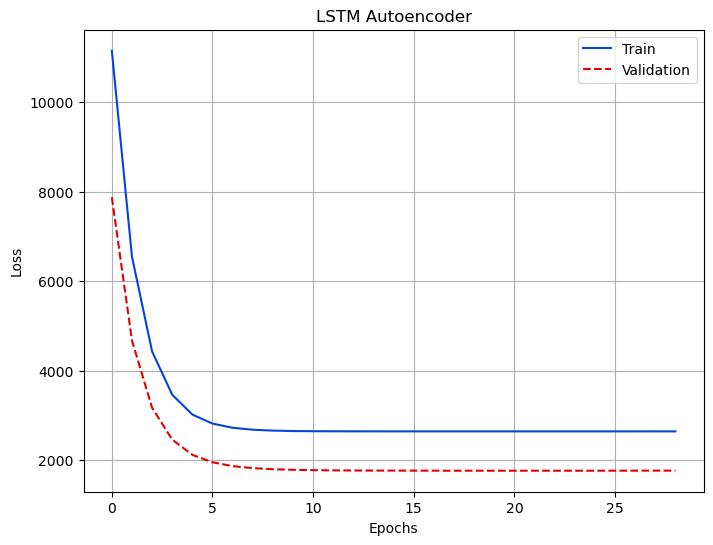

In [247]:
# Plot Train and Val loss
viz.plot_loss(history.history['loss'], history.history['val_loss'], title = 'LSTM Autoencoder')

In [248]:
class ThresholdEstimator:

    def __init__(self) -> None:
        self.mu        = 0
        self.sigma     = 1
        self.threshold = None

    def fit(self, model, data, target):

        # Reconstruct the data
        reconstructions = model.predict(data)
        print("Reconstructions:")
        print(reconstructions[:5, :5])
        print("Data:")
        print(data[:5, :5])
        errors = tf.keras.losses.mse(self._compress_array(reconstructions), self._compress_array(data))
        
        # Estimate the normal distribution of the errors
        self.mu    = np.mean(errors, axis = 0)
        self.sigma = np.cov(errors)

        #likelihoods = multivariate_normal.pdf(errors, mean=self.mu, cov=self.sigma)
        likelihoods  = norm.pdf(errors, loc=self.mu, scale=self.sigma)
        print("Likelihoods:")
        print(likelihoods[:5])

        f_list = []
        
        #step_size = int((max(likelihoods) - min(likelihoods)) / 1000) # Too small for arange
        thresholds = np.linspace(min(likelihoods), max(likelihoods), 100)
        
        for t in thresholds:

            preds = (likelihoods<t).astype(int)
            f = fbeta_score(target, preds, beta=0.1)
            f_list.append(f)

        bidx = np.argmax(f_list)
        
        self.best_threshold = np.max(errors)
        #self.best_threshold = np.quantile(errors, 0.95) #thresholds[bidx]

        return self
    
    def _compress_array(self, array):
        compressed_array = [array[sample, array.shape[1]-1, :] for sample in range(array.shape[0])]
    
        return compressed_array
    
    def predict(self, model, data, target):
        
        reconstructions = model.predict(data)
        errors = np.array(tf.keras.losses.mse(self._compress_array(reconstructions), self._compress_array(data)))
        print(errors[:5])
#         #likelihoods = multivariate_normal.pdf(errors, mean=self.mu, cov=self.sigma)
#         #likelihoods = norm.pdf(errors, loc=self.mu, scale=self.sigma)
#         likelihoods = np.array(errors)
#         print(likelihoods[:5])
#        pred_labels = (likelihoods < self.best_threshold).astype(int)
        likelihoods = errors
        pred_labels = (errors > self.best_threshold).astype(int)
        return likelihoods, pred_labels

In [249]:
# Fit the threshold using the validation dataset.
ter = ThresholdEstimator()

ter.fit(autoencoder, val_data, y_val)

56/56 [==============================] - 1s 4ms/step
Reconstructions:
[[[ 89.50729   96.19905 ]
  [102.95004  110.76814 ]
  [105.60337  113.63286 ]
  [106.2417   114.3165  ]
  [106.446106 114.53363 ]]

 [[ 89.5072    96.19895 ]
  [102.94898  110.76701 ]
  [105.6024   113.63185 ]
  [106.24091  114.315674]
  [106.445465 114.53296 ]]

 [[ 89.50716   96.19891 ]
  [102.94793  110.7659  ]
  [105.601425 113.63081 ]
  [106.24012  114.314835]
  [106.44481  114.53227 ]]

 [[ 89.507164  96.19892 ]
  [102.947495 110.76546 ]
  [105.60103  113.63039 ]
  [106.23981  114.314514]
  [106.44455  114.532   ]]

 [[ 89.50726   96.19903 ]
  [102.94714  110.76509 ]
  [105.600685 113.630035]
  [106.23953  114.314224]
  [106.44433  114.53177 ]]]
Data:
[[[105.2 134. ]
  [ 97.8 112. ]
  [ 83.2  88. ]
  [ 76.   74. ]
  [ 74.2  68. ]]

 [[ 97.8 112. ]
  [ 83.2  88. ]
  [ 76.   74. ]
  [ 74.2  68. ]
  [ 68.4  73. ]]

 [[ 83.2  88. ]
  [ 76.   74. ]
  [ 74.2  68. ]
  [ 68.4  73. ]
  [ 62.2  83. ]]

 [[ 76.   74. ]
  

/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [259]:
test_preds, test_labels = ter.predict(autoencoder, data[train_idx], target[train_idx])

fpr_test, tpr_test, thresh_test = roc_curve(target[train_idx], test_preds)
ppr_test, rec_test, pthresh_test = precision_recall_curve(target[train_idx], test_preds)

print("Test AU-ROC: ", auc(fpr_test, tpr_test))
print("Test AU-PRC: ", auc(rec_test, ppr_test))
print("F-0.1 Score: ", fbeta_score(target[train_idx], test_labels, beta=0.1))

75/75 [==============================] - 0s 4ms/step
[4145.09023805 5012.99711477 3293.57592948  531.04505817   44.05546095]
Test AU-ROC:  0.8255558939993908
Test AU-PRC:  0.037868042645954086
F-0.1 Score:  0.0


In [178]:
### Try a convolutional model
conv_model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(train_data.shape[1], train_data.shape[2])),
        tf.keras.layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        tf.keras.layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        tf.keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        
        tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(2, activation = 'relu'))
    ]
)
conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")

In [183]:
conv_history = conv_model.fit(
    train_data,
    train_data,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)


Epoch 1/50
132/132 [==============================] - 1s 6ms/step - loss: 0.4260 - val_loss: 0.2181
Epoch 2/50
132/132 [==============================] - 1s 6ms/step - loss: 0.4219 - val_loss: 0.2232
Epoch 3/50
132/132 [==============================] - 1s 6ms/step - loss: 0.4199 - val_loss: 0.2173
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.4194 - val_loss: 0.2165
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.4191 - val_loss: 0.2137
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.4174 - val_loss: 0.2232
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.4174 - val_loss: 0.2148
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.4184 - val_loss: 0.2130
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.4168 - val_loss: 0.2138
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.4161 - val_loss: 0.2078

<AxesSubplot:title={'center':'Convolutional Autoencoder'}, xlabel='Epochs', ylabel='Loss'>

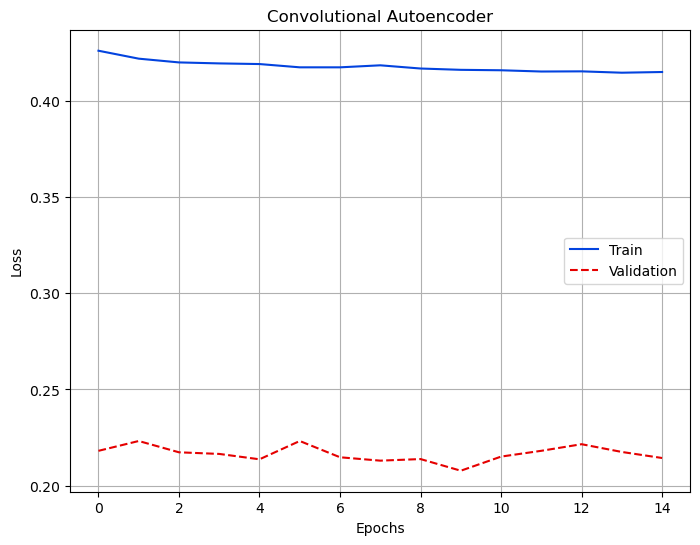

In [184]:
# Plot Train and Val loss
viz.plot_loss(conv_history.history['loss'], conv_history.history['val_loss'], title = 'Convolutional Autoencoder')

In [181]:
tcr = ThresholdEstimator()

tcr.fit(conv_model, val_data, y_val)

ctest_preds, ctest_labels = tcr.predict(conv_model, test_data, y_test)

cfpr_test, ctpr_test, cthresh_test = roc_curve(y_test, ctest_preds)
cppr_test, crec_test, cpthresh_test = precision_recall_curve(y_test, ctest_preds)

print("Test AU-ROC: ", auc(cfpr_test, ctpr_test))
print("Test AU-PRC: ", auc(crec_test, cppr_test))
print("F-0.1 Score: ", fbeta_score(y_test, ctest_labels, beta=1))

56/56 [==============================] - 0s 3ms/step
Reconstructions:
[[[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]]
Data:
[[[-0.09977341  0.46922637]
  [-0.24597474  0.03457376]
  [-0.53442601 -0.43959272]
  [-0.67667595 -0.71618983]
  [-0.71223844 -0.83473145]]

 [[-0.24597474  0.03457376]
  [-0.53442601 -0.43959272]
  [-0.67667595 -0.71618983]
  [-0.71223844 -0.83473145]
  [-0.82682867 -0.73594676]]

 [[-0.53442601 -0.43959272]
  [-0.67667595 -0.71618983]
  [-0.71223844 -0.83473145]
  [-0.82682867 -0.73594676]
  [-0.94932168 -0.5383774 ]]

 [[-0.67667595 -0.71618983]
  [-0.71223844 -0.83473145]
  [-0.82682867 -0.73594676]
  [-0.94932168 -0.5383774 ]
  [-1.02044665 -0.63716208]]

 [[-0.71223844 -0.83473145]
  [-0.82682867 -0.73594676]
  [-0.94932168 -0.5383774 ]
  [-1.020446

/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


183/183 [==============================] - 1s 3ms/step
Test AU-ROC:  0.008499313186813203
Test AU-PRC:  0.0010342450575084308
F-0.1 Score:  0.0


In [182]:
# def get_optimal_threshold(errors, target):

#     # Estimate the normal distribution of the errors
#     mu_vector  = np.mean(errors, axis = 0)
#     cov_matrix = np.cov(errors)

#     likelihoods = norm.pdf(errors, loc=mu_vector, scale=cov_matrix) * errors
#     print(likelihoods[:5])
#     f_list = []
#     thresholds = np.arange(min(likelihoods), max(likelihoods), 0.001)
#     print(thresholds)
#     for t in thresholds:

#         preds = (likelihoods<t).astype(int)
#         f = fbeta_score(target, preds, beta=0.1)
#         f_list.append(f)

#     best_threshold = np.argmax(f_list)

#     return likelihoods, thresholds[best_threshold]

def compress_array(array):
     compressed_array = [array[sample, array.shape[1]-1, :] for sample in range(array.shape[0])]
    
     return compressed_array

# def reconstruct(model, data, target, threshold=None):
#     reconstructions = model.predict(data)
#     errors = tf.keras.losses.mae(compress_array(reconstructions), compress_array(data))

#     if threshold is None:
#         errors, threshold = get_optimal_threshold(errors, target)
# # 
#     #preds = predict_scores(model, data, threshold)

#     return errors, threshold

### Reconstruction Comparison

In [39]:
reconstructions = conv_model.predict(train_data)
errors = tf.keras.losses.mae(compress_array(reconstructions), compress_array(train_data))

74/74 [==============================] - 0s 2ms/step


<AxesSubplot:ylabel='Count'>

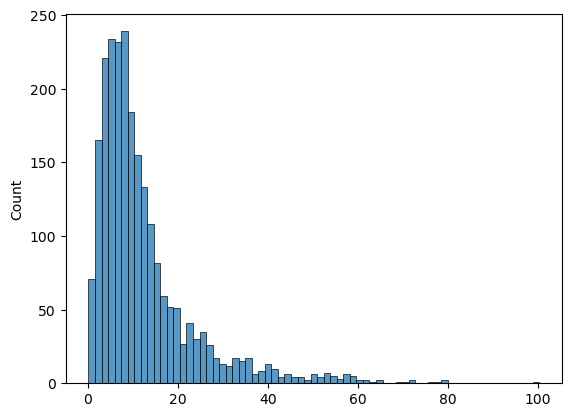

In [40]:
sns.histplot(errors)

In [41]:
val_reconstructions = conv_model.predict(val_data)
val_errors = tf.keras.losses.mae(compress_array(val_reconstructions), compress_array(val_data))

56/56 [==============================] - 0s 3ms/step


In [28]:
np.unique(test_labels)

array([0, 1])

In [29]:
from scipy.stats import norm

norm.pdf(errors, loc=mu_vector, scale = cov_matrix)

NameError: name 'mu_vector' is not defined

In [ ]:
multivariate_normal.pdf(errors, mean=mu_vector, cov=cov_matrix)

<AxesSubplot:ylabel='Count'>

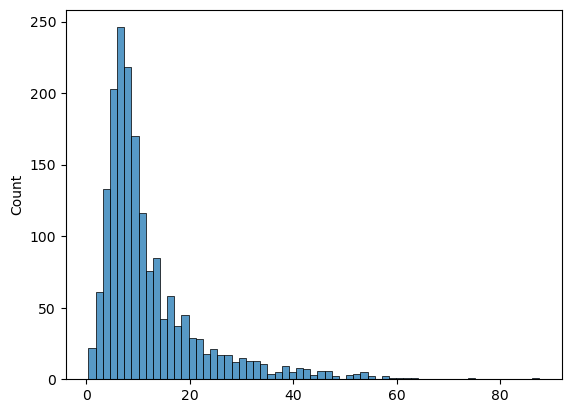

In [42]:
sns.histplot(val_errors)

In [43]:
atrain_reconstructions = conv_model.predict(anomalous_train)
atrain_errors = tf.keras.losses.mae(compress_array(atrain_reconstructions), compress_array(anomalous_train))

2/2 [==============================] - 0s 3ms/step


<AxesSubplot:ylabel='Count'>

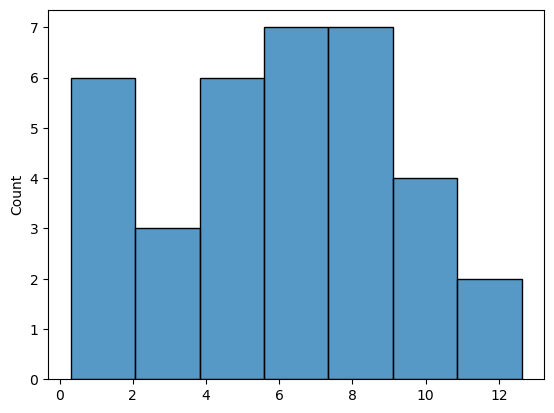

In [44]:
sns.histplot(atrain_errors)

1/1 [==============================] - 0s 20ms/step


<AxesSubplot:ylabel='Count'>

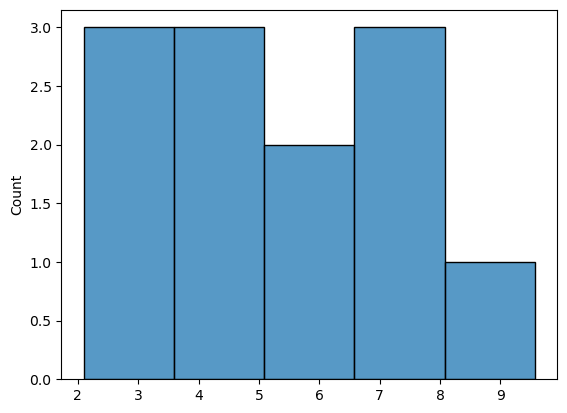

In [45]:
aval_reconstructions = conv_model.predict(anomalous_val)
aval_errors = tf.keras.losses.mae(compress_array(aval_reconstructions), compress_array(anomalous_val))

sns.histplot(aval_errors)

In [ ]:
### See the reconstruction loss on the Training Dataset
train_scores, threshold = reconstruct(autoencoder, train_data, y_train, threshold=None)

In [ ]:
threshold

In [ ]:
len(train_scores)

In [ ]:
sum(train_scores> threshold)

In [ ]:
val_scores, _ = reconstruct(autoencoder, val_data, y_val, threshold = threshold)

In [ ]:
val_scores

In [ ]:
### Run hypertuning
tuner = kt.Hyperband(model,
                        objective='val_loss',
                        max_epochs=100,
                        factor=3,
                        overwrite=True,
                        directory='test-3-jk',
                        project_name='lstm-autoencoder')

# Run the hypertuning search
tuner.search(train_data, train_data, epochs=50, validation_data = (val_data, val_data), batch_size=512,
            callbacks=[early_stopping], class_weight=train_weights)